## Описание на проекта

Идеята на проекта ми е да направя модел, който е способен да класифицира различни типове токсичност на коментари от социални медии в интернет.

Коментарите са класифицирани в следните 6 категории:
-  toxic
-  severe_toxic
-  obscene
-  threat
-  insult
-  identity_hate

Dataset: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

c:\users\aleksandar stanev\appdata\local\programs\python\python37-32\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [3]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [4]:
print(train.shape)
print(test.shape)

(159571, 8)
(153164, 2)


Train data-та съдържа по ред за всеки коментар, съответно с id, текст и 6 категории, които ще предсказваме.

In [5]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


Както се вижда, някои коментари могат да бъдат класифицирани в повече от една категория. Нека разгледаме няколко коментара.

In [6]:
train['comment_text'][0] 

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [7]:
train['comment_text'][6]

'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK'

Вижда се, че дължината на коментарите варира доста.

In [8]:
lens = train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(394.0732213246768, 590.7202819048919, 5000)

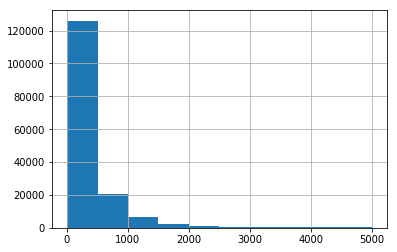

In [9]:
lens.hist();

Да проверим дали има липсващи стойности.

In [10]:
print("Missing values in Train dataset")
null_check = train.isnull().sum()
print(null_check)
print("Missing values in Test dataset")
null_check = test.isnull().sum()
print(null_check)

Missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
Missing values in Test dataset
id              0
comment_text    0
dtype: int64


In [11]:
print("Empty comments in Train dataset")
empty_comments = train[train['comment_text'] == ""]
print(len(empty_comments))
print("Empty comments in Test dataset")
empty_comments = test[test['comment_text'] == ""]
print(len(empty_comments))

Empty comments in Train dataset
0
Empty comments in Test dataset
0


Всичко изглежда наред. Ще направим лист с всички колони, които ще predict-ваме и ще добавим колона за това дали даден коментар е чист(не е от никоя категория) за визуализация.

In [12]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['clean'] = 1 - train[label_cols].max(axis = 1)
print("Number of clean comments in Train detaset")
print(train['clean'].sum())

Number of clean comments in Train detaset
143346


Нека видим как са разпределени категориите в train dataset-а. 

In [13]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


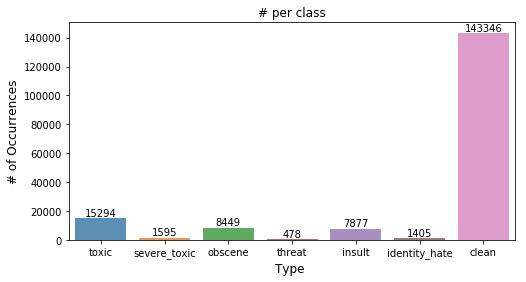

In [14]:
x = train.iloc[:,2:].sum()

plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

Видяхме, че някои коментари са класифицирани в повече от една категория. Да видим и колко коментара имат по няколко тага.

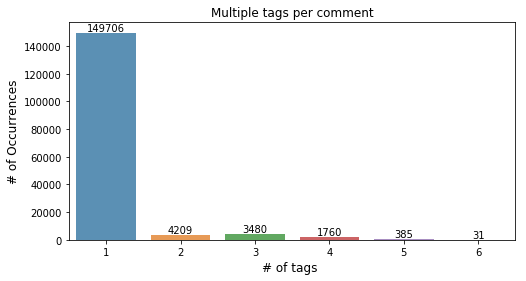

In [15]:
rowsums = train.iloc[:,2:].sum(axis=1)
x = rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

Ще се опитаме да намерим някаква корелация между различните лейбъли, които търсим.

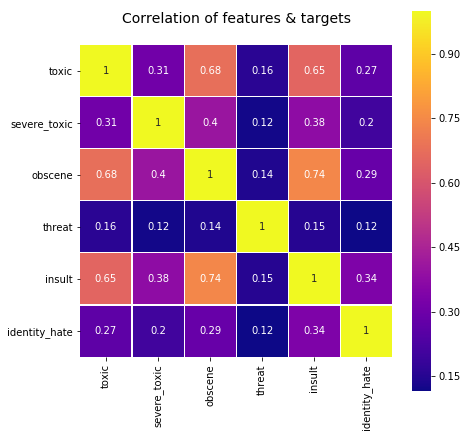

In [16]:
data = train[label_cols]
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

Наистина - изглежда, че има високи корелации между отделни лейбъли. Най-високата корелация е при insult-obscene - 0.74, след това са obscene-toxic и insult-toxic. Ще се опитаме да се възползваме от тези корелации в бъдещ модел.

### Идеи за feature-и
-  CountVectorizer, TfidfVectorizer, HashingVectorizer
-  Дължина на коментара - мисля си, че ядосаните хора ще пишат по-къси коментари
-  Брой думи - по същата логика мисля, че токсичните коментари трябва да съдържат по-малко думи
-  Колко главни букви има в коментара - често токсичните коментари са all caps
-  Каква част от коментара е главни букви - същата логика като горното
-  Колко удивителни знаци има - ядосаните хора вероятно слагат доста удивителни
-  Брой пунктуационни знаци - вероятно когато си ядосан не би спазвал пунктуационните правила

### Splitting the train dataset

In [17]:
from sklearn.model_selection import train_test_split

train_comment = train['comment_text'];
train_labels = train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']];

x_train, x_test, y_train, y_test = train_test_split(train_comment,
                                                    train_labels, 
                                                    test_size=0.3, 
                                                    random_state=4330)

print('x_train - {}'.format(x_train.shape));
print('x_test  - {}'.format(x_test.shape));
print('y_train - {}'.format(y_train.shape));
print('y_test  - {}'.format(y_test.shape));

x_train - (111699,)
x_test  - (47872,)
y_train - (111699, 6)
y_test  - (47872, 6)


### Vectorize the data

In [18]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
vect = CountVectorizer(max_features = 5000)
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [19]:
X_dtm = vect.fit_transform(x_train)
X_dtm

<111699x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 4255008 stored elements in Compressed Sparse Row format>

In [20]:
test_X_dtm = vect.transform(x_test)
test_X_dtm

<47872x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 1821083 stored elements in Compressed Sparse Row format>

### Baseline model
#### Solving a multi-label classification problem
Ще решим класификация за няколко label-а като я разделим на отделни еднокласови класификации. В нашия случай ще разделим проблема на 6 класификации за всеки label. Първо ще ги разгледаме като напълно независими проблеми(Binary Relevance).

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
logreg = LogisticRegression(C = 12.0)

def binary_relevance():
    for label in label_cols:
        print('... Processing {}'.format(label))
        # train the model using X_dtm & y
        
        logreg.fit(X_dtm, y_train[label])
        # compute the training accuracy
        y_pred_X = logreg.predict(test_X_dtm)
        print('Training accuracy is {}'.format(accuracy_score(y_test[label], y_pred_X)))

In [22]:
print("Testing with CountVectorizer")

binary_relevance()

Testing with CountVectorizer
... Processing toxic


c:\users\aleksandar stanev\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\aleksandar stanev\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training accuracy is 0.9467120655080213
... Processing severe_toxic
Training accuracy is 0.9907461564171123
... Processing obscene
Training accuracy is 0.9707762366310161
... Processing threat
Training accuracy is 0.9971382018716578
... Processing insult
Training accuracy is 0.9584099264705882
... Processing identity_hate
Training accuracy is 0.9904745989304813


Виждаме че baseline модела с CountVectorizer получава прилични резултати. Можем да пробваме с TfidfVectorizer, HashingVectorizer и да си поиграем с параметрите им.

Да видим с TfidftVectorizer и HashingVectorizer.

In [23]:
print("Testing with TfidfVectorizer")

vect = TfidfVectorizer(max_features = 5000)
X_dtm = vect.fit_transform(x_train)
test_X_dtm = vect.transform(x_test)

binary_relevance()

Testing with TfidfVectorizer
... Processing toxic
Training accuracy is 0.9582845922459893
... Processing severe_toxic
Training accuracy is 0.9904537098930482
... Processing obscene
Training accuracy is 0.9784425133689839
... Processing threat
Training accuracy is 0.9977439839572193
... Processing insult
Training accuracy is 0.9705673462566845
... Processing identity_hate
Training accuracy is 0.9917488302139037


In [24]:
print("Testing with HashingVectorizer")

vect = HashingVectorizer()
X_dtm = vect.fit_transform(x_train)
test_X_dtm = vect.transform(x_test)

binary_relevance()

Testing with HashingVectorizer
... Processing toxic
Training accuracy is 0.9603317179144385
... Processing severe_toxic
Training accuracy is 0.9906208221925134
... Processing obscene
Training accuracy is 0.9787767379679144
... Processing threat
Training accuracy is 0.9976813168449198
... Processing insult
Training accuracy is 0.9716535762032086
... Processing identity_hate
Training accuracy is 0.9917070521390374


#### Classifier Chains

С неограничен брой итерации получаваме най-добри резултати с TfidfVectorizer, затова ще се опитаме да оптимизираме него. Първото, което ще направим е да не разглеждаме 6те класификации като различни проблеми, а да търсим някакви корелации. Първия фийчър ще бъде трениран само с X, а всеки следващ ще бъде трениран с X плюс вече предположените класификации. По този начин ще можем да се възползваме от корелации между различните лейбъли(Classifier Chains).

In [25]:
from scipy.sparse import csr_matrix, hstack

def add_feature(X, feature_to_add):
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

def classifier_chains(X_dtm, test_X_dtm):
    avr = 0;
    for label in label_cols:
        print('... Processing {}'.format(label))
        # train the model using X_dtm & y
        logreg.fit(X_dtm,y_train[label])
        # compute the training accuracy
        y_pred_X = logreg.predict(test_X_dtm)
        accuracy = accuracy_score(y_test[label],y_pred_X);
        print('Training Accuracy is {}'.format(accuracy));
        avr += accuracy;
        # chain current label to X_dtm
        X_dtm = add_feature(X_dtm, y_train[label])
        test_X_dtm = add_feature(test_X_dtm, y_test[label])
        print('Shape of X_dtm is now {}'.format(X_dtm.shape))
    return avr / len(label_cols);

In [26]:
vect = TfidfVectorizer(max_features = 5000)
X_dtm = vect.fit_transform(x_train)
test_X_dtm = vect.transform(x_test)

avr = classifier_chains(X_dtm, test_X_dtm)
print('Average is {}'.format(avr));

... Processing toxic
Training Accuracy is 0.9582845922459893
Shape of X_dtm is now (111699, 5001)
... Processing severe_toxic
Training Accuracy is 0.9904119318181818
Shape of X_dtm is now (111699, 5002)
... Processing obscene
Training Accuracy is 0.9782962901069518
Shape of X_dtm is now (111699, 5003)
... Processing threat
Training Accuracy is 0.9978066510695187
Shape of X_dtm is now (111699, 5004)
... Processing insult
Training Accuracy is 0.975622493315508
Shape of X_dtm is now (111699, 5005)
... Processing identity_hate
Training Accuracy is 0.992730614973262
Shape of X_dtm is now (111699, 5006)
Average is 0.9821920955882352


Със Classifier Chains малко подобрихме резултатите.

#### Stemming

Да пробваме и stemming.

In [27]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

stem = PorterStemmer()

def stemString(t):
    try:
        return " ".join([stem.stem(w) for w in t.split()]);
    except RecursionError:
        return t;

x_train = x_train.apply(stemString)
x_test = x_test.apply(stemString)

x_train.head(5)

32172     corrupt archiv link It appear that most of the...
128348    I don't give a fli fuck. block me I don't care...
100126    " request edit could someon edit the section "...
44808     thi articl ha signific tone issu thi articl is...
124432    counterexampl I think it would be interest to ...
Name: comment_text, dtype: object

In [35]:
vect = TfidfVectorizer(max_features = 5000)
X_dtm = vect.fit_transform(x_train)
test_X_dtm = vect.transform(x_test)

avr = classifier_chains(X_dtm, test_X_dtm)
print('Average is {}'.format(avr));

... Processing toxic
Training Accuracy is 0.9594126002673797
Shape of X_dtm is now (111699, 5001)
... Processing severe_toxic
Training Accuracy is 0.9901194852941176
Shape of X_dtm is now (111699, 5002)
... Processing obscene
Training Accuracy is 0.9784007352941176
Shape of X_dtm is now (111699, 5003)
... Processing threat
Training Accuracy is 0.9977230949197861
Shape of X_dtm is now (111699, 5004)
... Processing insult
Training Accuracy is 0.9759358288770054
Shape of X_dtm is now (111699, 5005)
... Processing identity_hate
Training Accuracy is 0.9926679478609626
Shape of X_dtm is now (111699, 5006)
Average is 0.9823766154188949


Като че ли stemming-а леко подобрява резултатите ни. Ще го използваме.

Ще пробваме и с различните ръчни фийчъри, които споменахме по-горе.

In [36]:
train_features = pd.DataFrame();
test_features = pd.DataFrame();

train_features['total_length'] = x_train.apply(len)
train_features['capitals'] = x_train.apply(lambda comment: sum(1 for c in comment if c.isupper()))
train_features['caps_vs_length'] = train_features['total_length'] / train_features['total_length']
train_features['num_exclamation_marks'] = x_train.apply(lambda comment: comment.count('!'))
train_features['num_punctuation'] = x_train.apply(lambda comment: sum(comment.count(w) for w in '.,;:'))
train_features['num_words'] = x_train.apply(lambda comment: len(comment.split()))

test_features['total_length'] = x_test.apply(len)
test_features['capitals'] = x_test.apply(lambda comment: sum(1 for c in comment if c.isupper()))
test_features['caps_vs_length'] = test_features['capitals'] / test_features['total_length']
test_features['num_exclamation_marks'] = x_test.apply(lambda comment: comment.count('!'))
test_features['num_punctuation'] = x_test.apply(lambda comment: sum(comment.count(w) for w in '.,;:'))
test_features['num_words'] = x_test.apply(lambda comment: len(comment.split()))

print(train_features.head(5))

        total_length  capitals  caps_vs_length  num_exclamation_marks  \
32172            244         5             1.0                      0   
128348            88         3             1.0                      0   
100126           302         3             1.0                      0   
44808            163         0             1.0                      0   
124432           169         1             1.0                      0   

        num_punctuation  num_words  
32172                 6         49  
128348                3         18  
100126                8         58  
44808                 3         27  
124432                2         31  


Ще опитаме с всяка от тези колони и ще видим кои подобряват резултата ни.

In [37]:
X_dtm = vect.fit_transform(x_train)
test_X_dtm = vect.transform(x_test)

for col in train_features:
    print("Trying with " +  col);
    X_dtm_copy = X_dtm.copy();
    test_X_dtm_copy = test_X_dtm.copy();
    
    X_dtm_copy = add_feature(X_dtm_copy, train_features[col]);
    test_X_dtm_copy = add_feature(test_X_dtm_copy, test_features[col]);
    
    avr = classifier_chains(X_dtm_copy, test_X_dtm_copy);
    print('Average is {}'.format(avr));
    
    print("\n");

Trying with total_length
... Processing toxic
Training Accuracy is 0.9592037098930482
Shape of X_dtm is now (111699, 5002)
... Processing severe_toxic
Training Accuracy is 0.9902448195187166
Shape of X_dtm is now (111699, 5003)
... Processing obscene
Training Accuracy is 0.9797794117647058
Shape of X_dtm is now (111699, 5004)
... Processing threat
Training Accuracy is 0.9977439839572193
Shape of X_dtm is now (111699, 5005)
... Processing insult
Training Accuracy is 0.9772936163101604
Shape of X_dtm is now (111699, 5006)
... Processing identity_hate
Training Accuracy is 0.9927515040106952
Shape of X_dtm is now (111699, 5007)
Average is 0.9828361742424243


Trying with capitals
... Processing toxic
Training Accuracy is 0.9593917112299465
Shape of X_dtm is now (111699, 5002)
... Processing severe_toxic
Training Accuracy is 0.9901612633689839
Shape of X_dtm is now (111699, 5003)
... Processing obscene
Training Accuracy is 0.9783798462566845
Shape of X_dtm is now (111699, 5004)
... Processi

Колоните, които подобряват резултата ни са - total_length, num_exclamation_marks, num_words. Ще използваме тях в финалния модел.

### Финалния модел ще ни бъде:
-  Tfidf Vectorizer
-  със stemming
-  с няколко допълнителни ръчни фийчъри

In [41]:
X_dtm = add_feature(X_dtm_copy, train_features['total_length']);
X_dtm = add_feature(X_dtm_copy, train_features['num_exclamation_marks']);
X_dtm = add_feature(X_dtm_copy, train_features['num_words']);

test_X_dtm = add_feature(test_X_dtm_copy, test_features['total_length']);
test_X_dtm = add_feature(test_X_dtm_copy, test_features['num_exclamation_marks']);
test_X_dtm = add_feature(test_X_dtm_copy, test_features['num_words']);

avr = classifier_chains(X_dtm, test_X_dtm);
print('Average is {}'.format(avr));

... Processing toxic
Training Accuracy is 0.9593917112299465
Shape of X_dtm is now (111699, 5003)
... Processing severe_toxic
Training Accuracy is 0.9902657085561497
Shape of X_dtm is now (111699, 5004)
... Processing obscene
Training Accuracy is 0.9782962901069518
Shape of X_dtm is now (111699, 5005)
... Processing threat
Training Accuracy is 0.9977439839572193
Shape of X_dtm is now (111699, 5006)
... Processing insult
Training Accuracy is 0.9757478275401069
Shape of X_dtm is now (111699, 5007)
... Processing identity_hate
Training Accuracy is 0.9926888368983957
Shape of X_dtm is now (111699, 5008)
Average is 0.9823557263814617
